## Packages

In [16]:
%load_ext watermark

import numpy as np
import xarray as xr
import pandas as pd
import xcdat as xc

import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import regionmask

import cmocean.cm as cmo

%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
cartopy   : 0.22.0
regionmask: 0.11.0
sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
xarray    : 2023.10.1
pandas    : 2.2.0
numpy     : 1.24.4
matplotlib: 3.8.0
cmocean   : 3.0.3
scipy     : 1.11.3
xcdat     : 0.6.0



## Figure settings

In [17]:
%config InlineBackend.figure_formats = ['png']
mpl.rcParams['figure.dpi'] = 150

# Functions

In [18]:
def format_ds_coords(ds):
    ds = ds.bounds.add_bounds('X')
    ds = ds.bounds.add_bounds('Y')
    ds = xc.swap_lon_axis(ds, (-180, 180))
    return ds

def calculate_annual_timeseries(da):
    """
    Calculates the annual timeseries, weighted by the number of days in each month
    """
    nyears = len(da.groupby('time.year'))
    month_length = da.time.dt.days_in_month

    weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()        
    np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(nyears)) 

    return (da * weights).groupby('time.year').sum(dim='time')

In [19]:
# Load tree ring coordinates
tree_ring_coords = pd.read_csv('./latlon_gym_ang.csv', usecols=[0,1,2])
tree_ring_coords = tree_ring_coords.rename(columns={'gym=0/ang=1': 'isAng'})
tree_ring_coords = tree_ring_coords.replace({'isAng': np.nan}, 2)

# Select ang/gym tree ring coordinates
ang_coords = tree_ring_coords.loc[tree_ring_coords['isAng']==1].drop(columns='isAng')
gym_coords = tree_ring_coords.loc[tree_ring_coords['isAng']==0].drop(columns='isAng')

# Create sets of ang/gym site indices
ang_site_set = set(ang_coords.index.tolist())
gym_site_set = set(gym_coords.index.tolist())

# Create slice objects to select the corresponding ang/gym tree PFTs
angtreepft_index_slice = slice(4,8)
gymtreepft_index_slice = slice(1,3)
natpft_index_slice = slice(0,14)

tree_type_index_slice = {
    'ang': angtreepft_index_slice,
    'gym': gymtreepft_index_slice,
}

In [20]:
ang_coords.index.values

array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 323, 324, 325, 326, 327, 328, 329, 330, 331,
       335, 336, 337, 340, 343, 344, 350, 351, 352, 353, 354, 355, 358,
       359, 361, 364, 369, 380, 386, 393, 409, 410])

# Load CLM variables

In [57]:
ltype_name = [
    'vegetated_or_bare_soil',
    'crop',
    'UNUSED',
    'landice_multiple_elevation_classes',
    'deep_lake',
    'wetland',
    'urban_tbd',
    'urban_hd',
    'urban_md',
]

main_directory = '/glade/work/bbuchovecky/WUE_analysis'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'

pct_natpft = xr.open_dataset(f'{main_directory}/{case_name}.clm2.h3.PCT_NAT_PFT.18500101-20141231.nc')
pct_natpft = format_ds_coords(pct_natpft)
pct_natpft = pct_natpft['PCT_NAT_PFT'].rename({'natpft':'pft'}).assign_coords({'pft':np.arange(15)}) / 100

pct_landunit = xr.open_dataset(f'{main_directory}/{case_name}.clm2.h3.PCT_LANDUNIT.18500101-20141231.nc')
pct_landunit = format_ds_coords(pct_landunit)
pct_landunit = pct_landunit['PCT_LANDUNIT'].assign_coords({'ltype':np.arange(9)}) / 100

pct_natpft_gridbox = pct_natpft * pct_landunit.isel(ltype=0)

In [59]:
main_directory = '/glade/work/bbuchovecky/WUE_analysis'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'

variables = [
    # 'GPP',
    # 'GSSUNLN',
    # 'FCTR',
    'TLAI',
    # 'WUE'
]

conv_factors = {
    'GPP': 60 * 60 * 24 * 365,
    'GSSUNLN': 1 / 1000,
    'FCTR': 1000 * 1000 / 2.26e6,
    'TLAI': 1,
    'WUE': 1,
}

pct_natpft_threshold = 0

site_mon_pft = {}
site_ann_pft = {}
grid_ann_pft = {}

for var in variables:
    print(var)

    # Load site-level model output
    site_mon_pft[var] = xr.open_dataset(f'{main_directory}/sites_from_gridded/{case_name}.clm2.h1.{var}.185001-201412_sites.nc')

    # Format site-level model output
    site_mon_pft[var] = site_mon_pft[var].sel(time=slice('1851-01', '2014-12'), pft=natpft_index_slice)[var]
    site_mon_pft[var] = site_mon_pft[var] * conv_factors[var]

    # Compute annual mean for site-level model output
    site_ann_pft[var] = calculate_annual_timeseries(site_mon_pft[var])

    # Load grid-level model output
    grid_ann_pft[var] = xr.open_dataset(f'{main_directory}/timeseries_from_gridded/{case_name}.clm2.h1.{var}.185001-201412_gridded_annts.nc')
    
    # Format grid-level model output
    grid_ann_pft[var] = format_ds_coords(grid_ann_pft[var])
    grid_ann_pft[var] = grid_ann_pft[var].sel(year=slice(1851, 2014), pft=natpft_index_slice)[var]
    grid_ann_pft[var] = grid_ann_pft[var] * conv_factors[var]
    
    # Select grid boxes where the natural PFTs exist
    grid_ann_pft[var] = grid_ann_pft[var].where(pct_natpft_gridbox.min(dim='time')>pct_natpft_threshold)

TLAI


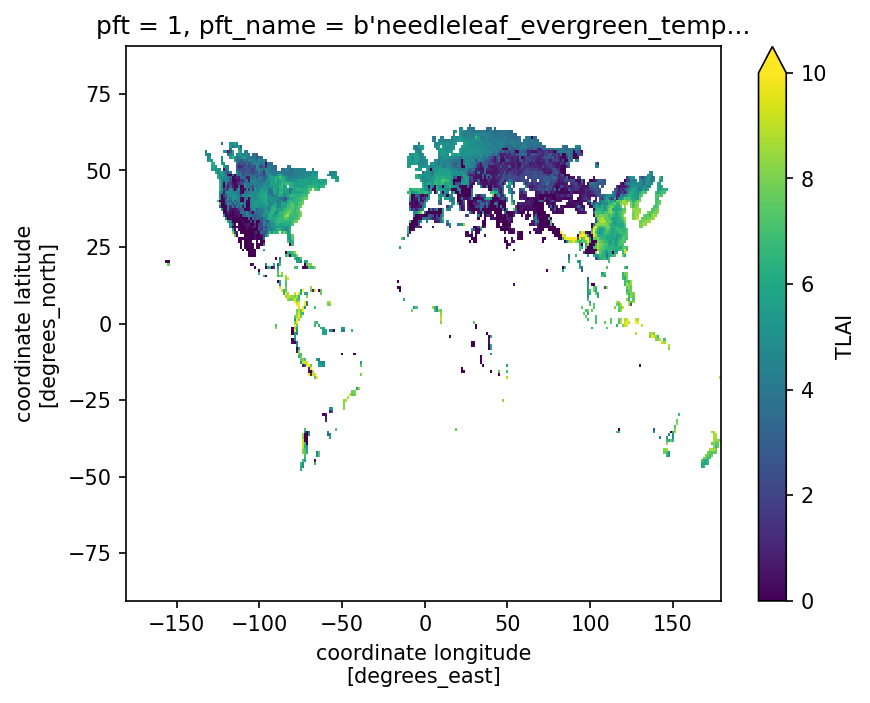

In [60]:
grid_ann_pft['TLAI'].isel(pft=1, year=-1).plot(vmin=0, vmax=10)

# The problem

Text(0.5, 1.0, 'total projected leaf area')

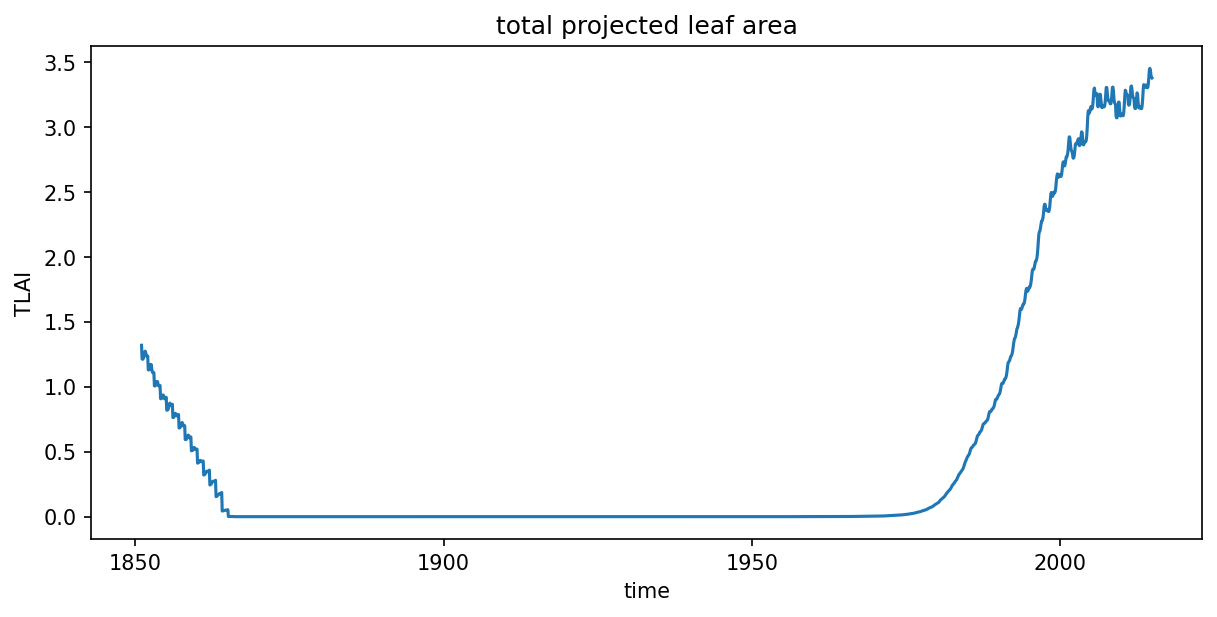

In [ ]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')

site_mon_pft['TLAI'].isel(pft=1, site=157).plot(ax=ax)
ax.set_title('total projected leaf area')

Text(0.5, 1.0, 'TLAI>0.25 by site and pft')

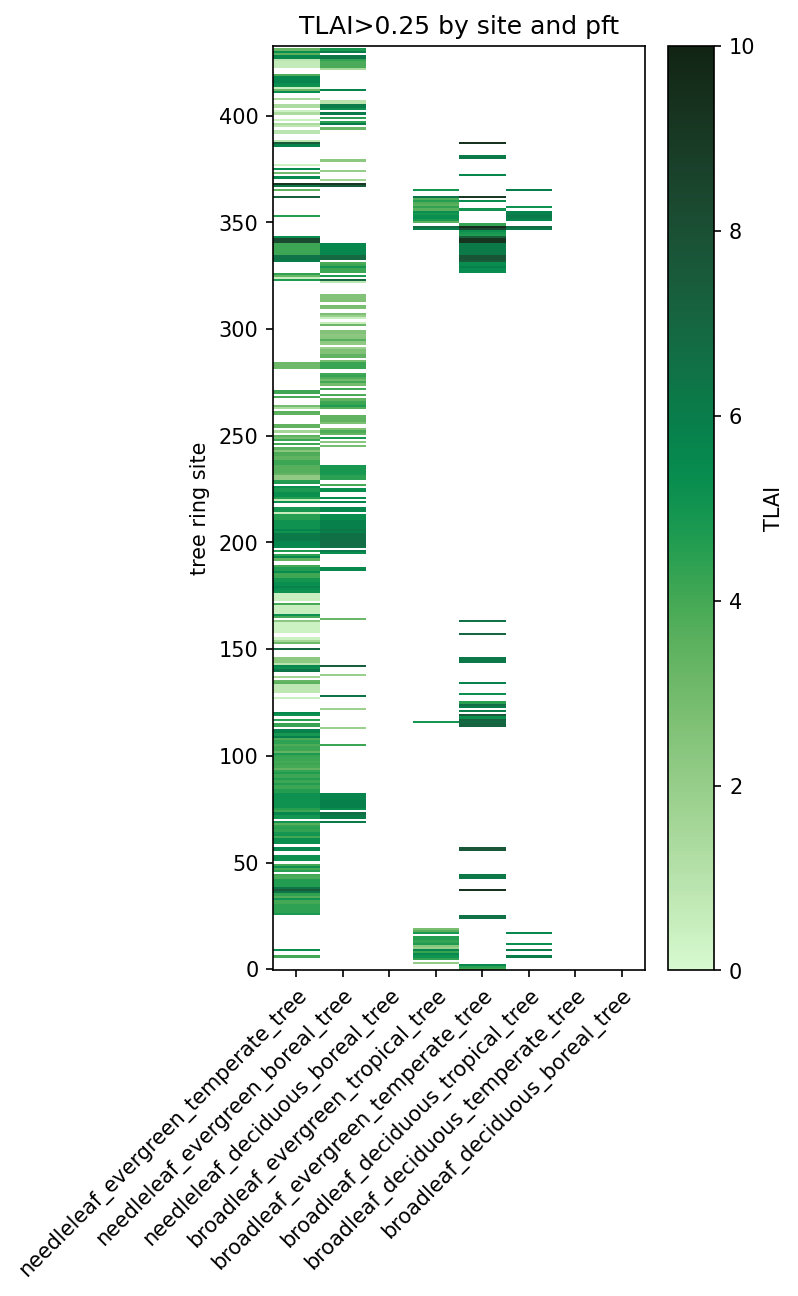

In [ ]:
site_mon_pft['TLAI'].mean(dim='time').sel(pft=slice(1,8)).where(site_mon_pft['TLAI'].min(dim='time')>0.25).plot(
    figsize=(4,8), cmap=cmo.algae, vmin=0, vmax=10, add_labels=False, cbar_kwargs={'label': 'TLAI'})

plt.xticks(
    ticks=np.arange(1,9),
    labels=[ str(label)[2:-1].strip() for label in site_mon_pft['TLAI'].sel(pft=slice(1,8)).pft_name.values],
    rotation=45, ha='right', rotation_mode='anchor',
);
plt.ylabel('tree ring site');
plt.title('TLAI>0.25 by site and pft')

# Find sites that share grid boxes in CLM

In [ ]:
example_site_da = site_ann_pft['TLAI'].isel(year=0, pft=0)

unique_gridbox_indices = []
unique_coords = []

# For each site, a list of sites (including itself) that share its grid box in CLM
repeat_gridbox_indices = np.empty(433, dtype=object)
for i in range(433):
    repeat_gridbox_indices[i] = [i]

repeat_lat_coords = []
repeat_lon_coords = []
repeat_coords = []

for s in example_site_da:
    this_site = s.site.values.item()
    this_lon = s.lon.values.item()
    this_lat = s.lat.values.item()
    this_coord = [this_lon, this_lat]
    
    if this_coord in unique_coords:
        orig_site_da = example_site_da.sel(site=unique_gridbox_indices[unique_coords.index(this_coord)])
        orig_site = orig_site_da.site.values.item()

        # print(f'{this_site} {this_lon: 0.4f} {this_lat: 0.4f}')
        # print(f'--{orig_site} {orig_site_da.lon.values.item(): 0.4f} {orig_site_da.lat.values.item(): 0.4f}')

        for this_repeat_site in repeat_gridbox_indices[orig_site][1:]:
            repeat_gridbox_indices[this_repeat_site].append(this_site)
            repeat_gridbox_indices[this_site].append(this_repeat_site)
        repeat_gridbox_indices[orig_site].append(this_site)
        repeat_gridbox_indices[this_site].append(orig_site)

        repeat_coords.append(this_coord)
    
    else:
        unique_gridbox_indices.append(this_site)
        unique_coords.append([this_lon, this_lat])

# For each site, the number of sites (including itself) that share its grid box in CLM
gridbox_per_site = np.ones(433)
for i in range(433):
    gridbox_per_site[i] = len(repeat_gridbox_indices[i])

    # Sort the sites in the same grid box
    repeat_gridbox_indices[i] = sorted(repeat_gridbox_indices[i])

print('number of unique grid box coordinates:   ', len(unique_coords))
print('number of repeated grid box coordinates: ', len(repeat_coords))
print('total number of coordinates:             ', len(unique_coords) + len(repeat_coords))

number of unique grid box coordinates:    291
number of repeated grid box coordinates:  142
total number of coordinates:              433


In [ ]:
np.array(unique_gridbox_indices).size
# np.array(unique_coords)

291

In [ ]:
# For each site, the number of sites (including itself) that share its grid box in CLM
gridbox_per_site

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1.,
       1., 2., 1., 2., 2., 2., 2., 2., 2., 1., 4., 4., 4., 4., 2., 2., 1.,
       2., 1., 3., 2., 3., 4., 4., 4., 4., 1., 1., 4., 1., 2., 7., 1., 2.,
       7., 7., 7., 2., 1., 2., 2., 1., 6., 6., 1., 2., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 2., 3., 1., 5., 9., 9., 9., 9., 3., 3., 3., 1., 3.,
       2., 2., 3., 2., 3., 1., 2., 1., 1., 3., 2., 1., 2., 3., 3., 1., 1.,
       1., 2., 2., 1., 2., 2., 1., 1., 1., 2., 2., 1., 2., 2., 1., 1., 1.,
       1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 3., 3., 3., 1., 1.,
       4., 1., 1., 4., 3., 1., 1., 1., 3., 3., 3., 2., 3., 3., 1., 3., 1.,
       1., 1., 6., 4., 1., 6., 6., 6., 6., 6., 1., 1., 2., 7., 6., 6., 6.,
       6., 1., 1., 6., 3., 3., 3., 7., 6., 2., 6., 6., 2., 2., 2., 2., 1.,
       2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 3., 3., 4., 4., 4.,
       4., 9., 1., 9., 9., 9., 9., 5., 5., 5., 2., 2., 2., 1., 1., 1., 2.,
       5., 3., 3., 2., 2.

In [ ]:
# For each site, a list of sites (including itself) that share its grid box in CLM
repeat_gridbox_indices

array([list([0]), list([1]), list([2]), list([3]), list([4]), list([5]),
       list([6]), list([7]), list([8]), list([9]), list([10]), list([11]),
       list([12]), list([13]), list([14, 15]), list([14, 15]), list([16]),
       list([17]), list([18, 358]), list([19]), list([20, 21]),
       list([20, 21]), list([22, 23]), list([22, 23]), list([24, 25]),
       list([24, 25]), list([26]), list([27, 28, 29, 30]),
       list([27, 28, 29, 30]), list([27, 28, 29, 30]),
       list([27, 28, 29, 30]), list([31, 32]), list([31, 32]), list([33]),
       list([34, 419]), list([35]), list([36, 38, 140]), list([37, 387]),
       list([36, 38, 140]), list([39, 40, 41, 42]),
       list([39, 40, 41, 42]), list([39, 40, 41, 42]),
       list([39, 40, 41, 42]), list([43]), list([44]),
       list([45, 156, 409, 410]), list([46]), list([47, 165]),
       list([48, 51, 52, 53, 166, 177, 414]), list([49]), list([50, 54]),
       list([48, 51, 52, 53, 166, 177, 414]),
       list([48, 51, 52, 53, 166, 

In [ ]:
these_sites = [76, 77, 78, 79, 205, 207, 208, 209, 210]

for this_site in these_sites:
    print(f'{example_site_da.sel(site=this_site).site.values.item()} {example_site_da.sel(site=this_site).lon.values.item(): 0.4f} {example_site_da.sel(site=this_site).lat.values.item(): 0.4f}')

76  7.5000  46.6492
77  7.5000  46.6492
78  7.5000  46.6492
79  7.5000  46.6492
205  7.5000  46.6492
207  7.5000  46.6492
208  7.5000  46.6492
209  7.5000  46.6492
210  7.5000  46.6492


# Find sites with minLAI>0.25

## Create DataArrays and save

In [62]:
main_directory = '/glade/work/bbuchovecky/WUE_analysis/sites_from_gridded'

lai_threshold = 0.25

# Create list of sets of site indices
all_sites_above_lai0p25 = []

for pft in range(1,15):

    # Get all sites with minimum monthly LAI > threshold
    these_sites = []
    for s in site_mon_pft['TLAI'].sel(pft=pft).min(dim='time'):
        if s.values.item() > lai_threshold:
            these_sites.append(s.site.values.item())
    
    # Store site indices as a set
    all_sites_above_lai0p25.append(set(these_sites))
    
    if len(these_sites) > 0:
        # Get the DataArray coordinate of site indices
        sites_above_lai0p25 = site_ann_pft['TLAI'].sel(pft=pft, site=np.array(these_sites)).site
        
        # Save these coordinates as NetCDF
        this_pft_name = str(sites_above_lai0p25.pft_name.values.item())[2:-1].strip()
        sites_above_lai0p25 = sites_above_lai0p25.assign_attrs({
            'long_name': f'indices of tree ring sites where monthly LAI > {lai_threshold: 0.3f} for {this_pft_name}'
        })
        sites_above_lai0p25 = sites_above_lai0p25.to_dataset(name=f'pft{str(pft).zfill(2)}_sites_above_lai0p25')
        # sites_above_lai0p25.to_netcdf(f'{main_directory}/sites_above_lai0p25/pft{str(pft).zfill(2)}_sites_above_lai0p25.nc')

    print(f'{str(pft).zfill(2)} {str(sites_above_lai0p25.pft_name.values.item())[2:-1]} - {str(len(these_sites)).zfill(3)} sites with LAI >{lai_threshold: 0.3f}')

# Perform union of all sets of needleleaf sites
needleleaf_sites_above_lai0p25 = np.array(list(all_sites_above_lai0p25[1] | all_sites_above_lai0p25[2] | all_sites_above_lai0p25[3]))

# Format and save these coordinates as NetCDF
needleleaf_sites_above_lai0p25 = site_mon_pft['TLAI'].site.sel(site=needleleaf_sites_above_lai0p25)
needleleaf_sites_above_lai0p25 = needleleaf_sites_above_lai0p25.assign_attrs({
    'long_name': f'indices of tree ring sites where monthly LAI > {lai_threshold: 0.3f} for needleaf PFTs'
})
needleleaf_sites_above_lai0p25 = needleleaf_sites_above_lai0p25.to_dataset(name='needleleaf_sites_above_lai0p25')
# needleleaf_sites_above_lai0p25.to_netcdf(f'{main_directory}/sites_above_lai0p25/needleleaf_sites_above_lai0p25.nc')

# Perform union of all sets of broadleaf sites
broadleaf_sites_above_lai0p25 = np.array(list(all_sites_above_lai0p25[4] | all_sites_above_lai0p25[5] | all_sites_above_lai0p25[6] | all_sites_above_lai0p25[7] | all_sites_above_lai0p25[8]))

# Format and save these coordinates as NetCDF
broadleaf_sites_above_lai0p25 = site_mon_pft['TLAI'].site.sel(site=broadleaf_sites_above_lai0p25)
broadleaf_sites_above_lai0p25 = broadleaf_sites_above_lai0p25.assign_attrs({
    'long_name': f'indices of tree ring sites where monthly LAI > {lai_threshold: 0.3f} for needleaf PFTs'
})
broadleaf_sites_above_lai0p25 = broadleaf_sites_above_lai0p25.to_dataset(name='broadleaf_sites_above_lai0p25')
# broadleaf_sites_above_lai0p25.to_netcdf(f'{main_directory}/sites_above_lai0p25/broadleaf_sites_above_lai0p25.nc')

print(f'needleleaf - {len(needleleaf_sites_above_lai0p25.site)} sites with LAI >{lai_threshold: 0.3f}')
print(f'broadleaf - {len(broadleaf_sites_above_lai0p25.site)} sites with LAI >{lai_threshold: 0.3f}')

01 needleleaf_evergreen_temperate_tree      - 258 sites with LAI > 0.250
02 needleleaf_evergreen_boreal_tree         - 144 sites with LAI > 0.250
03 needleleaf_evergreen_boreal_tree         - 000 sites with LAI > 0.250
04 broadleaf_evergreen_tropical_tree        - 032 sites with LAI > 0.250
05 broadleaf_evergreen_temperate_tree       - 057 sites with LAI > 0.250
06 broadleaf_deciduous_tropical_tree        - 013 sites with LAI > 0.250
07 broadleaf_deciduous_tropical_tree        - 000 sites with LAI > 0.250
08 broadleaf_deciduous_tropical_tree        - 000 sites with LAI > 0.250
09 broadleaf_evergreen_shrub                - 049 sites with LAI > 0.250
10 broadleaf_deciduous_temperate_shrub      - 010 sites with LAI > 0.250
11 broadleaf_deciduous_temperate_shrub      - 000 sites with LAI > 0.250
12 broadleaf_deciduous_temperate_shrub      - 000 sites with LAI > 0.250
13 c3_non-arctic_grass                      - 014 sites with LAI > 0.250
14 c4_grass                                 - 014 s

## Create sets and save

In [ ]:
print('Number of total CLM grid boxes corresponding to gymnosperm sites that have >=1 needleleaf PFT with LAI>0.25:')
gym_site_above_lai0p25 = set(gym_site_set) & (all_sites_above_lai0p25[1] | all_sites_above_lai0p25[2] | all_sites_above_lai0p25[3])
print(len(gym_site_above_lai0p25))

print('Number of unique CLM grid boxes corresponding to gymnosperm sites that have >=1 needleleaf PFT with LAI>0.25:')
gym_unique_gridbox_above_lai0p25 = set(unique_gridbox_indices) & set(gym_site_set) & (all_sites_above_lai0p25[1] | all_sites_above_lai0p25[2] | all_sites_above_lai0p25[3])
print(len(gym_unique_gridbox_above_lai0p25))

Number of total CLM grid boxes corresponding to gymnosperm sites that have >=1 needleleaf PFT with LAI>0.25:
127
Number of unique CLM grid boxes corresponding to gymnosperm sites that have >=1 needleleaf PFT with LAI>0.25:
87


In [ ]:
print('Number of total CLM grid boxes corresponding to angiosperm sites that have >=1 broadleaf PFT with LAI>0.25:')
ang_site_above_lai0p25 = set(ang_site_set) & (all_sites_above_lai0p25[4] | all_sites_above_lai0p25[5] | all_sites_above_lai0p25[6] | all_sites_above_lai0p25[7] | all_sites_above_lai0p25[8])
print(len(ang_site_above_lai0p25))

print('Number of unique CLM grid boxes corresponding to angiosperm sites that have >=1 broadleaf PFT with LAI>0.25:')
ang_unique_gridbox_above_lai0p25 = set(unique_gridbox_indices) & set(ang_site_set) & (all_sites_above_lai0p25[4] | all_sites_above_lai0p25[5] | all_sites_above_lai0p25[6] | all_sites_above_lai0p25[7] | all_sites_above_lai0p25[8])
print(len(ang_unique_gridbox_above_lai0p25))

Number of total CLM grid boxes corresponding to angiosperm sites that have >=1 broadleaf PFT with LAI>0.25:
31
Number of unique CLM grid boxes corresponding to angiosperm sites that have >=1 broadleaf PFT with LAI>0.25:
24


In [ ]:
import pickle

main_directory = '/glade/work/bbuchovecky/WUE_analysis/sites_from_gridded'

with open(f'{main_directory}/sites_above_lai0p25/gym_site_above_lai0p25.pickle', 'wb') as handle:
    pickle.dump(gym_site_above_lai0p25, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{main_directory}/sites_above_lai0p25/gym_unique_gridbox_above_lai0p25.pickle', 'wb') as handle:
    pickle.dump(gym_unique_gridbox_above_lai0p25, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{main_directory}/sites_above_lai0p25/ang_site_above_lai0p25.pickle', 'wb') as handle:
    pickle.dump(ang_site_above_lai0p25, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{main_directory}/sites_above_lai0p25/ang_unique_gridbox_above_lai0p25.pickle', 'wb') as handle:
    pickle.dump(ang_unique_gridbox_above_lai0p25, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load sites with minLAI>0.25

In [ ]:
main_directory = '/glade/work/bbuchovecky/WUE_analysis/sites_from_gridded'
sites_above_lai0p25 = {}

for pft in [1, 2, 4, 5, 6, 9, 10, 13, 14]:
    sites_above_lai0p25[pft] = xr.open_dataset(f'{main_directory}/sites_above_lai0p25/pft{str(pft).zfill(2)}_sites_above_lai0p25.nc')
    sites_above_lai0p25[pft] = sites_above_lai0p25[pft][f'pft{str(pft).zfill(2)}_sites_above_lai0p25']

for pft in ['broad', 'needle']:
    sites_above_lai0p25[pft] = xr.open_dataset(f'{main_directory}/sites_above_lai0p25/{pft}leaf_sites_above_lai0p25.nc')
    sites_above_lai0p25[pft] = sites_above_lai0p25[pft][f'{pft}leaf_sites_above_lai0p25']

In [ ]:
import pickle

with open(f'{main_directory}/sites_above_lai0p25/gym_site_above_lai0p25.pickle', 'rb') as handle:
    gym_site_above_lai0p25 = pickle.load(handle)

with open(f'{main_directory}/sites_above_lai0p25/gym_unique_gridbox_above_lai0p25.pickle', 'rb') as handle:
    gym_unique_gridbox_above_lai0p25 = pickle.load(handle)

with open(f'{main_directory}/sites_above_lai0p25/ang_site_above_lai0p25.pickle', 'rb') as handle:
    ang_site_above_lai0p25 = pickle.load(handle)

with open(f'{main_directory}/sites_above_lai0p25/ang_unique_gridbox_above_lai0p25.pickle', 'rb') as handle:
    ang_unique_gridbox_above_lai0p25 = pickle.load(handle)

# Map of sites

Text(0.5, 1.0, 'CLM grid boxes corresponding to gymnosperm sites\n$\\geq$1 needleleaf PFT with LAI>0.25 (n=127 of 304)')

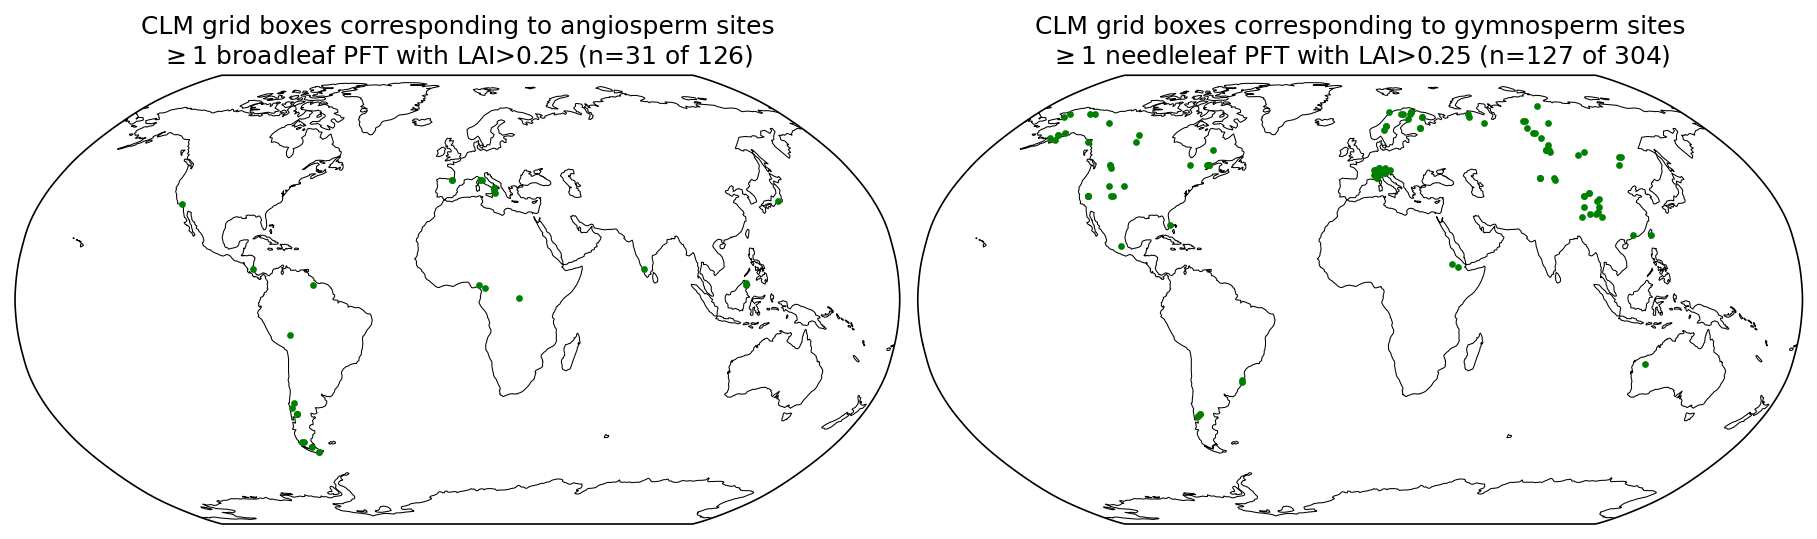

In [ ]:
fig, axes = plt.subplots(
    1, 2, figsize=(12,5),
    layout='constrained',
    subplot_kw={
        'projection': ccrs.Robinson()
    }
)
ax = axes.ravel()

for s in ang_site_above_lai0p25:
    ax[0].scatter(
        sites_above_lai0p25['broad'].sel(site=s).lon,
        sites_above_lai0p25['broad'].sel(site=s).lat,
        s=5, c='green',
        transform=ccrs.PlateCarree()
    )

for s in gym_site_above_lai0p25:
    ax[1].scatter(
        sites_above_lai0p25['needle'].sel(site=s).lon,
        sites_above_lai0p25['needle'].sel(site=s).lat,
        s=5, c='green',
        transform=ccrs.PlateCarree()
    )

for a in ax:
    a.coastlines(lw=0.5, zorder=0)
    a.set_extent((-180, 180, -90, 90))

ax[0].set_title('CLM grid boxes corresponding to angiosperm sites\n$\geq$1 broadleaf PFT with LAI>0.25 (n='+str(len(ang_site_above_lai0p25))+' of '+str(ang_coords.index.size)+')')
ax[1].set_title('CLM grid boxes corresponding to gymnosperm sites\n$\geq$1 needleleaf PFT with LAI>0.25 (n='+str(len(gym_site_above_lai0p25))+' of '+str(gym_coords.index.size)+')')

# Load trends

In [ ]:
main_directory = '/glade/work/bbuchovecky/WUE_analysis/trends'

trend_variable = [
    'GSSUNLN',
    'FCTR',
    'GPP',
    'TLAI',
    'WUE',
]

trend_period = {
    'full':'190101-201412',
    'early':'190101-196412',
    'late':'196501-201412',
}

trends = {}

for var in trend_variable:
    trends[var] = {}

    for key, dates in trend_period.items():
        trends[var][key] = xr.open_dataset(f'{main_directory}/{var}_linregress.{dates}.nc')[var]
        trends[var][key] = trends[var][key].rename({'vegtype': 'pft', 'vegtype_name': 'pft_name'})

In [ ]:
trends[var][key].stats_descr.values

array(['slope [X/10yr]', 'rvalue', 'pvalue'], dtype=object)

In [ ]:
trends['TLAI']['full']

<xarray.DataArray 'TLAI' (site: 433, pft: 14, stats: 3)>
[18186 values with dtype=float64]
Coordinates:
  * site         (site) int64 0 1 2 3 4 5 6 7 ... 426 427 428 429 430 431 432
  * pft          (pft) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    pft_name     (pft) |S40 ...
    is_ang       (pft) int64 ...
  * stats        (stats) int64 0 1 2
    stats_descr  (stats) object ...

In [ ]:
ds = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/sites_from_gridded/clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist.clm2.h1.FCTR.185001-201412_sites.nc')

In [ ]:
ds.sel(pft=slice(1,8))

<xarray.Dataset>
Dimensions:   (pft: 8, site: 433, time: 1980)
Coordinates:
  * pft       (pft) int64 1 2 3 4 5 6 7 8
    pft_name  (pft) |S40 b'needleleaf_evergreen_temperate_tree     ' ... b'br...
    lat       (site) float32 ...
  * time      (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
    lon       (site) float32 ...
  * site      (site) int64 0 1 2 3 4 5 6 7 8 ... 425 426 427 428 429 430 431 432
Data variables:
    FCTR      (site, time, pft) float32 ...
Attributes: (12/18)
    description:                          Gridded to (time,lat,lon,pft) then ...
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 04/27/21 13:27:32
    source:                               Community Terrestrial Systems Model
    ...                                   ...
    Surface_dataset:                      surfdata_0.9x1.25_hist_78pfts_CMIP6...
    Initial_conditions_dataset:           finidat_interp_dest.nc
    PFT_physiological_constants_dataset:  clm50_params.c210217.nc
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./clm50_cesm23a02cPPEn08ctsm51d030_...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...